# Data prep

In [1]:
# Test images analysis
import PIL
from PIL import Image
from os import listdir
from matplotlib.pyplot import imshow
import numpy as np
from collections import defaultdict
from collections import OrderedDict
from operator import itemgetter
import collections
import math
    
def build_my_test():
    test_images = listdir('./test_images/')
    test_images_array = []
    test_images_labels_array = []
    for test_image_filename in test_images:
        img = Image.open('./test_images/' + test_image_filename).convert('RGB')
        img = img.resize((32,32), PIL.Image.ANTIALIAS)
        test_images_array.append(np.asarray(img))
        test_images_labels_array.append((test_image_filename.split('_')[1].split('.')[0]))
        
#     print(test_images_array)
#     print(test_images_labels_array)
    return (test_images_array, test_images_labels_array)

import random

def show_sample_images(Xs, count, signnames_dict, make_random=True, labels=None, fig_title=None, CMAP=None):
    col_count = 5
    rows = math.ceil(float(len(Xs)) / float(col_count))
    fig = plt.figure(figsize=(4*int(col_count),2*rows))
    if fig_title:
        fig.suptitle(fig_title, fontsize=8)
    for i in range(count):
        if make_random:
            index = random.randint(0, len(Xs)-1)
            image = Xs[index].squeeze()
        else:
            image = Xs[i].squeeze()
        ax1 = fig.add_subplot(rows,col_count,i+1)
        ax1.set_title(labels[i] + ' occurences', fontsize=8)
        ax1.set_xticks([]) 
        ax1.set_yticks([]) 
        ax1.imshow(image, cmap=CMAP)

def build_feature_label_ranked_dict(X, Y):
    assert(len(X) == len(Y))
    label_feature_dict = {}
    for x,y in zip(X, Y):
        if y not in label_feature_dict:
            label_feature_dict[y] = x
    
    label_count_dict = defaultdict(int)
    for x,y in zip(X, Y):
        label_count_dict[y] += 1
    
    ranked_count_to_label_feature_dict = collections.OrderedDict()
    for label, count in sorted(label_count_dict.items(), key=lambda x:x[1]):
        ranked_count_to_label_feature_dict[str(signnames_dict[str(label)]) + ": " + str(count)] = label_feature_dict[label]
    
    return ranked_count_to_label_feature_dict

In [2]:
import matplotlib.pyplot as plt
# Load pickled data
import pickle
import numpy as np
from functools import partial
import csv

# TODO: Fill this in based on where you saved the training and testing data

DATA_DIR = "./data/"

training_file = DATA_DIR + "traffic-signs-data/train.p"
validation_file = DATA_DIR + "traffic-signs-data/valid.p"
testing_file = DATA_DIR + "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

(X_my_test, y_my_test) = build_my_test()    
    
X_train, X_train_coords, X_train_sizes, y_train = np.asarray(train['features'], dtype=np.float32), train['coords'], train['sizes'], train['labels']
X_valid, X_valid_coords,X_valid_sizes, y_valid = np.asarray(valid['features'], dtype=np.float32), valid['coords'], valid['sizes'], valid['labels']
X_test, X_test_coords, X_test_sizes, y_test = np.asarray(test['features'], dtype=np.float32), test['coords'], test['sizes'], test['labels']

# for k,v in build_feature_label_ranked_dict(X_train, y_train):
#     print (k)
#     print (v)
#################

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

In [3]:
def transformFeatures(transformFunc, XFeatures):
    return np.array([transformFunc(X_image) for X_image in XFeatures])

def saveAndRetrievePickle(transformFunc, featuresDict, mode, pickleFileName):
    if mode == 'saveAndRetrieve':
        X_train_features = np.array([transformFunc(X_train_image) for X_train_image in featuresDict['X_train']])
        X_valid_features = np.array([transformFunc(X_valid_image) for X_valid_image in featuresDict['X_valid']])
        X_test_features = np.array([transformFunc(X_test_image) for X_test_image in featuresDict['X_test']])
             
        new_features_dict = {'X_train': X_train_features, 'y_train': y_train, 'X_valid': X_valid_features,\
                            'y_valid': y_valid, 'X_test': X_test_features, 'y_test': y_test}
    
        with open(DATA_DIR + pickleFileName + '.pickle', 'wb') as handle:
            pickle.dump(new_features_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
      
    if mode == 'saveAndRetrieve' or mode == 'retrieve':
        with open(DATA_DIR + pickleFileName + '.pickle', 'rb') as handle:
            new_features_dict = pickle.load(handle)
    
    return new_features_dict
            
   
# Original_data
def noop_image(image):
    return np.asarray(image, dtype=np.float32) 

print("# Prepping Original_data")
original_data = {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}

# original_data = saveAndRetrievePickle(noop_image, original_data, 'saveAndRetrieve', 'original_data')
original_data = saveAndRetrievePickle(noop_image, original_data, 'retrieve', 'original_data') 

## My data
original_data['X_my_test'] = transformFeatures(noop_image, X_my_test)
original_data['y_my_test'] = y_my_test
##

# Create cropped data
#TODO(saajan): Reconsider zeroing out irrelevant area over resizing cropped image
def extract_bounds_and_rescale(image, coord, size):
    transformed_x = 32
    transformed_y = 32
    original_x = size[0]
    original_y = size[1]
      
    x_multiplier = float(transformed_x)/float(original_x)
    y_multiplier = float(transformed_y)/float(original_y)
      
    transformed_coord = (coord[0]* x_multiplier, coord[1] * y_multiplier, coord[2] * x_multiplier, coord[3] * y_multiplier)
    transformed_coord = [int(np.rint(val)) for val in transformed_coord]
      
    ret_image = image.copy()
    shape = image.shape
     
    ret_image[0:transformed_coord[0],:] = (0,0,0)
    ret_image[:,0:transformed_coord[1]] = (0,0,0)
    ret_image[transformed_coord[2]:shape[1],:] = (0,0,0)
    ret_image[:,transformed_coord[3]:shape[0]] = (0,0,0)
    #show_sample_images([ret_image], 1)
    return np.asarray(ret_image, dtype=np.float32)


# # extract_bounds_and_rescale Xs
# X_train = np.array([extract_bounds_and_rescale(image, coord, size) for (image, coord, size) in zip(X_train, X_train_coords, X_train_sizes)])
# X_valid = np.array([extract_bounds_and_rescale(image, coord, size) for (image, coord, size) in zip(X_valid, X_valid_coords,X_valid_sizes)])
# X_test = np.array([extract_bounds_and_rescale(image, coord, size) for (image, coord, size) in zip(X_test, X_test_coords, X_test_sizes)])
  
print("# Prepping Cropped_data")
# cropped_data = {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}
# with open(DATA_DIR + 'cropped_data.pickle', 'wb') as cropped_data_handle:
#     pickle.dump(cropped_data, cropped_data_handle, protocol=pickle.HIGHEST_PROTOCOL)
  
with open(DATA_DIR + 'cropped_data.pickle', 'rb') as cropped_data_handle:
    cropped_data = pickle.load(cropped_data_handle)
     
## My data -- noop
cropped_data['X_my_test'] = X_my_test
cropped_data['y_my_test'] = y_my_test
##
# show_sample_images(cropped_data['X_train'], 10)


# normalize Xs
def normalize(image, mean_pixel):
    result = (np.asarray(image, dtype=np.float32) - mean_pixel) / mean_pixel
    #normalizer_func = np.vectorize(lambda val: (float(val)-float(mean_pixel))/float(mean_pixel))
    return np.asarray(result, dtype=np.float32)

print("# Prepping Original_normalized_data")
# original_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in original_data['X_train']])), original_data, 'saveAndRetrieve', 'original_normalized_data')
original_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in original_data['X_train']])), original_data, 'retrieve', 'original_normalized_data')
## My data
original_normalized_data['X_my_test'] = transformFeatures(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in original_data['X_my_test']])), original_data['X_my_test'])
original_normalized_data['y_my_test'] = y_my_test
##

print("# Prepping Cropped_normalized_data")
# cropped_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_data['X_train']])), cropped_data, 'saveAndRetrieve', 'cropped_normalized_data')
cropped_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_data['X_train']])), cropped_data, 'retrieve', 'cropped_normalized_data')
## My data
cropped_normalized_data['X_my_test'] = transformFeatures(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_data['X_my_test']])), cropped_data['X_my_test'])
cropped_normalized_data['y_my_test'] = y_my_test
##  

# # Experiments
# vals = []
# for image in cropped_normalized_data['X_train']:
#     vals.append((np.mean(image)))
# print(np.mean(vals))    


import cv2
# convert_to_grayscale Xs
def convert_to_grayscale(image):
    return np.asarray(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), dtype=np.float32).reshape((32, 32, 1))
    
print("# Prepping Cropped_grayscale_data")
# cropped_grayscale_data = saveAndRetrievePickle(convert_to_grayscale, cropped_data, 'saveAndRetrieve', 'cropped_grayscale_data')
cropped_grayscale_data = saveAndRetrievePickle(convert_to_grayscale, cropped_data, 'retrieve', 'cropped_grayscale_data') 
## My data
cropped_grayscale_data['X_my_test'] = transformFeatures(convert_to_grayscale, cropped_data['X_my_test'])
cropped_grayscale_data['y_my_test'] = y_my_test
##

print("# Prepping Cropped_grayscaled_normalized_data")
# cropped_grayscaled_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_grayscale_data['X_train']])), cropped_grayscale_data, 'saveAndRetrieve', 'cropped_grayscaled_normalized_data')
cropped_grayscaled_normalized_data = saveAndRetrievePickle(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_grayscale_data['X_train']])), cropped_grayscale_data, 'retrieve', 'cropped_grayscaled_normalized_data') 
## My data
cropped_grayscaled_normalized_data['X_my_test'] = transformFeatures(partial(normalize, mean_pixel=np.mean([np.mean(image) for image in cropped_grayscale_data['X_my_test']])), cropped_grayscale_data['X_my_test'])
cropped_grayscaled_normalized_data['y_my_test'] = y_my_test
##

#Naming
original_data['name'] = 'original_data'
original_normalized_data['name'] = 'original_normalized_data'
cropped_data['name'] = 'cropped_data'
cropped_grayscale_data['name'] = 'cropped_grayscale_data'
cropped_normalized_data['name'] = 'cropped_normalized_data'
cropped_grayscaled_normalized_data['name'] = 'cropped_grayscaled_normalized_data'

#cmap
original_data['cmap'] = None
original_normalized_data['cmap'] = None
cropped_data['cmap'] = None
cropped_grayscale_data['cmap'] = 'gray'
cropped_normalized_data['cmap'] = None
cropped_grayscaled_normalized_data['cmap'] = 'gray'
all_data = [original_data, original_normalized_data, cropped_data, cropped_normalized_data, cropped_grayscale_data, cropped_grayscaled_normalized_data] 
#all_data = [original_normalized_data, cropped_grayscale_data] 
#all_data = [original_normalized_data] 

print('Done with data prep!')
print()

# Prepping Original_data
# Prepping Cropped_data
# Prepping Original_normalized_data
# Prepping Cropped_normalized_data
# Prepping Cropped_grayscale_data
# Prepping Cropped_grayscaled_normalized_data
Done with data prep!



# Data Summary

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


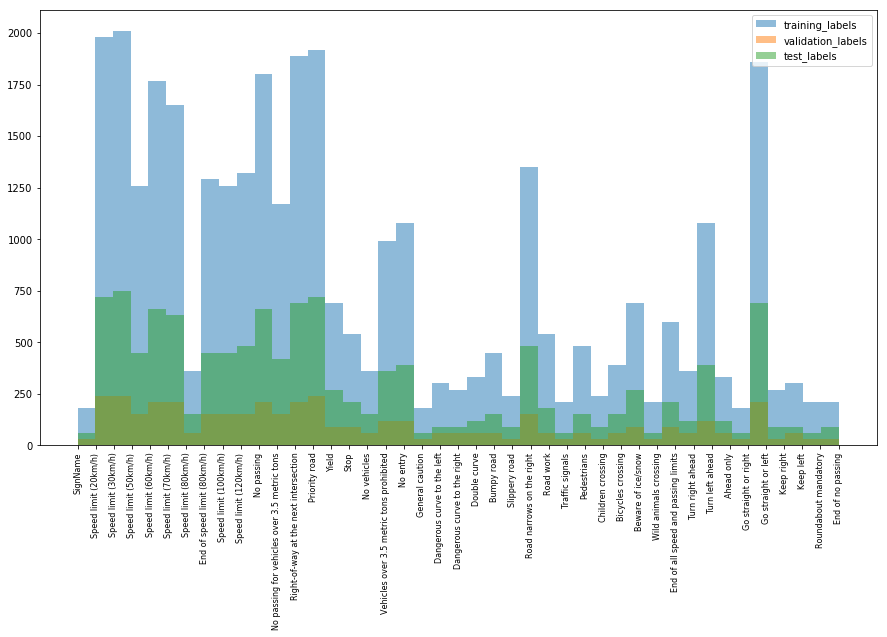

In [4]:
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

##################


### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
#TODO(saajan): uncomment line below and plot and do more visualization
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,8))
#bins = np.linspace(-5, 5, 25, endpoint=True)

signnames_dict = {}
signnames = [None]
with open('./signnames.csv') as signnamescsv:
    signnamesreader = csv.reader(signnamescsv, delimiter=',')
    for label, name in signnamesreader:
        signnames.append(name)
        signnames_dict[label] = name
ax.hist(y_train, alpha=0.5, label='training_labels', bins=43)
ax.hist(y_valid, alpha=0.5, label='validation_labels', bins=43)
ax.hist(y_test, alpha=0.5, label='test_labels', bins=43)
ind = np.arange(43)  # the x locations for the groups
width = 0
ax.set_xticks(ind + width)
ax.set_xticklabels(tuple(signnames[1:]))
#ax.tick_params(axis='x', which='major', labelsize=10, direction='')
#ax.tick_params(axis='x', direction='out', colors='r')
plt.xticks(rotation=90, linespacing=0, size=8)
plt.legend(loc='upper right')
plt.show()

###################
        #ax1.imshow(image, cmap="gray")
        
        #plt.imshow(image, cmap="gray")
        #plt.imshow(image)
           
# show_sample_images(X_train, 10)

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.    

# Sample images for each class and each transformed dataset

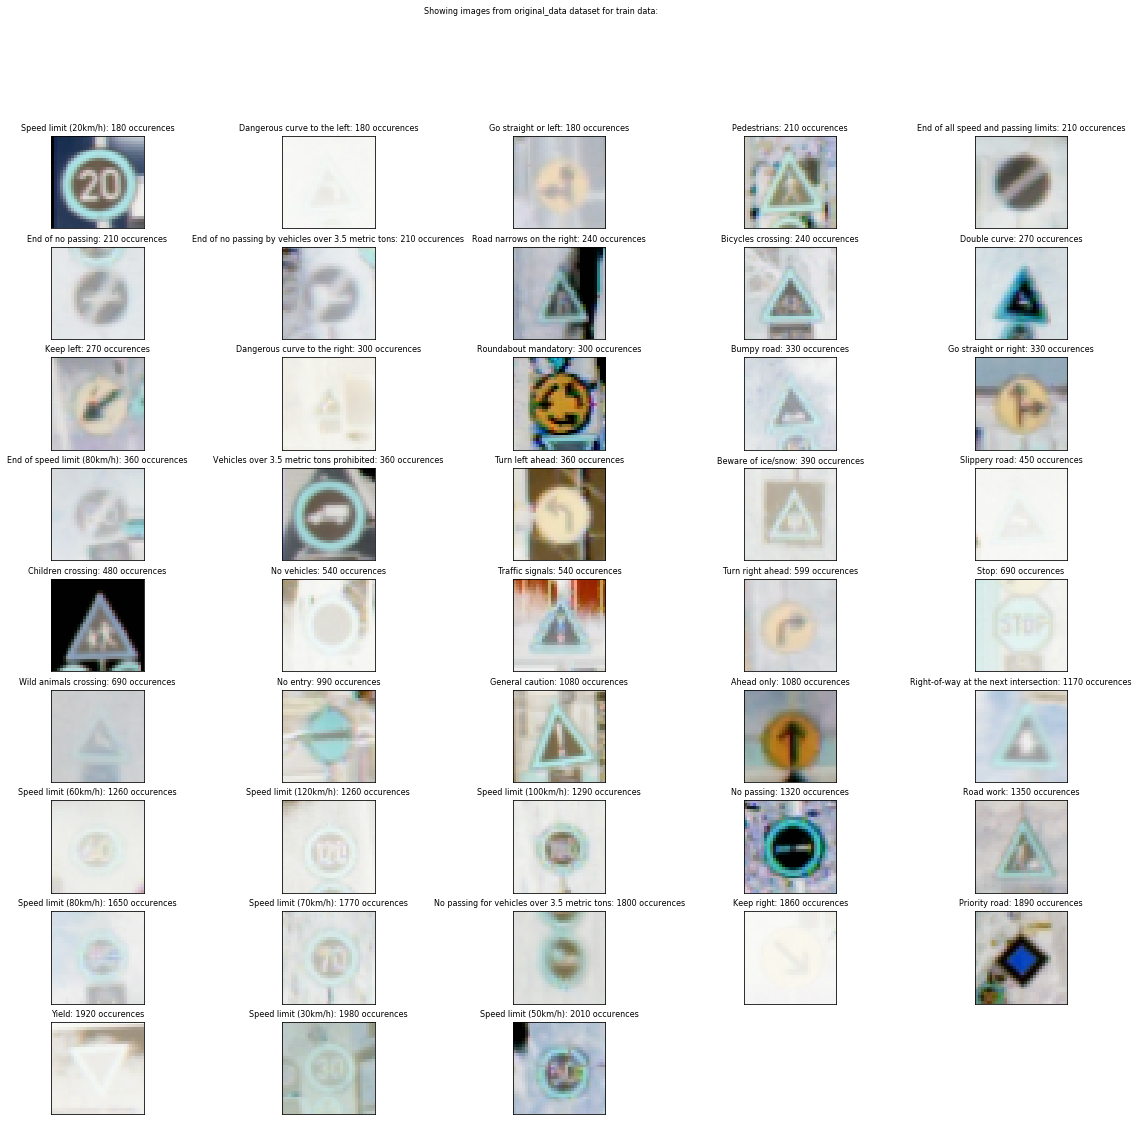

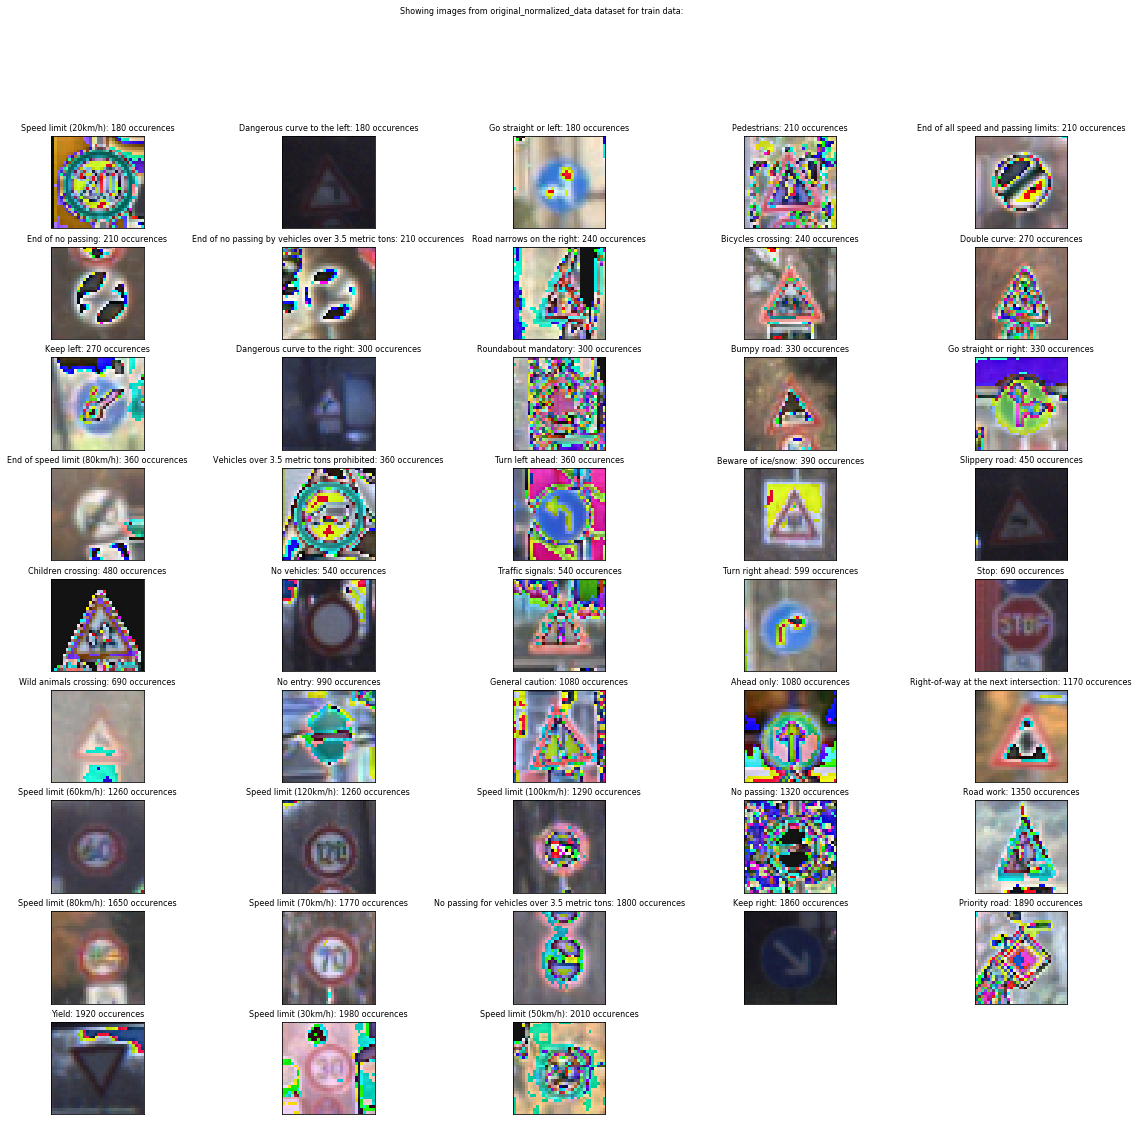

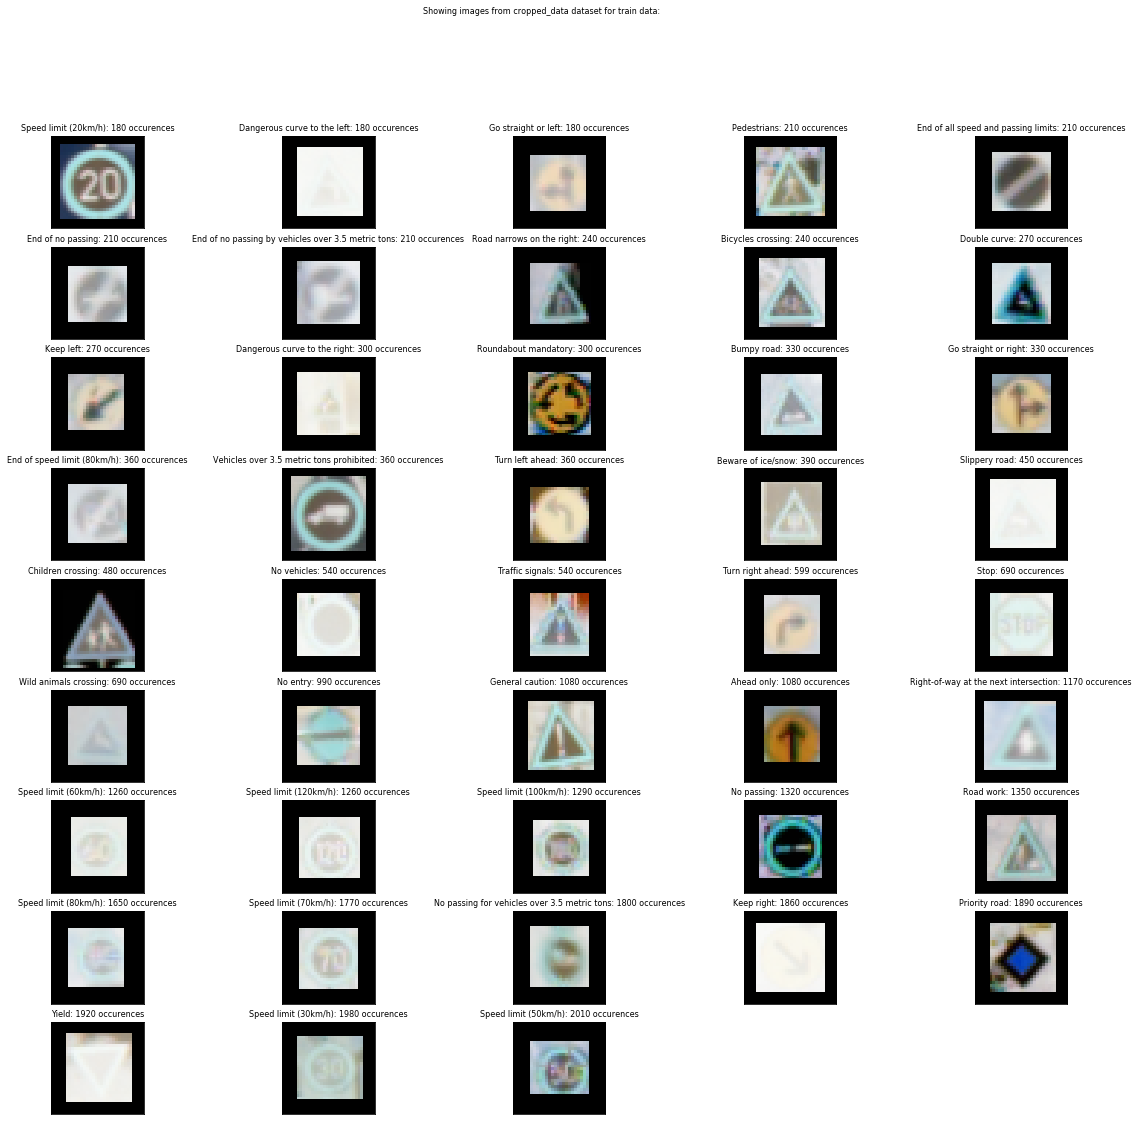

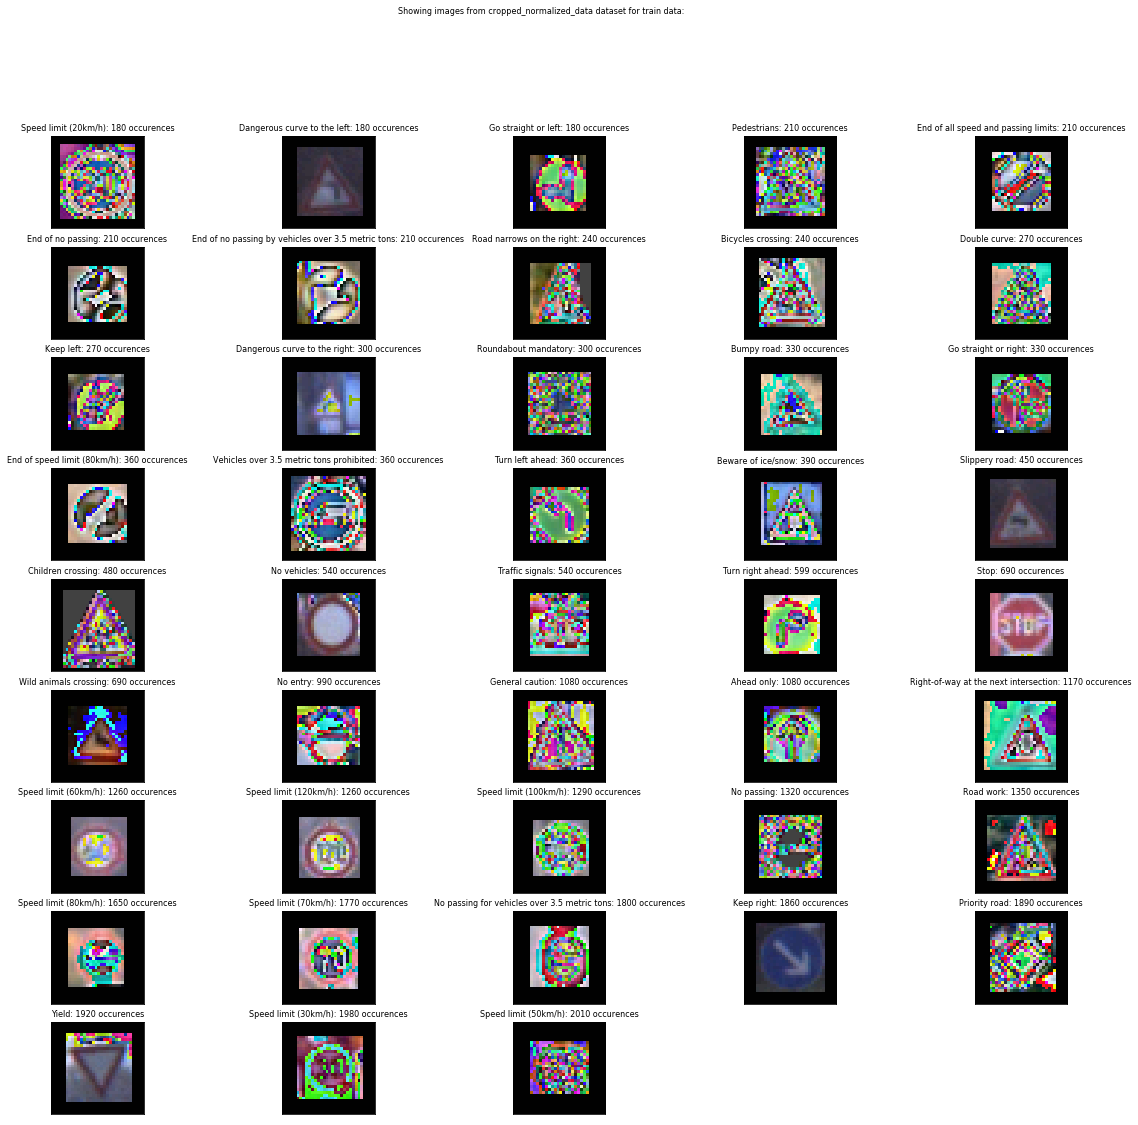

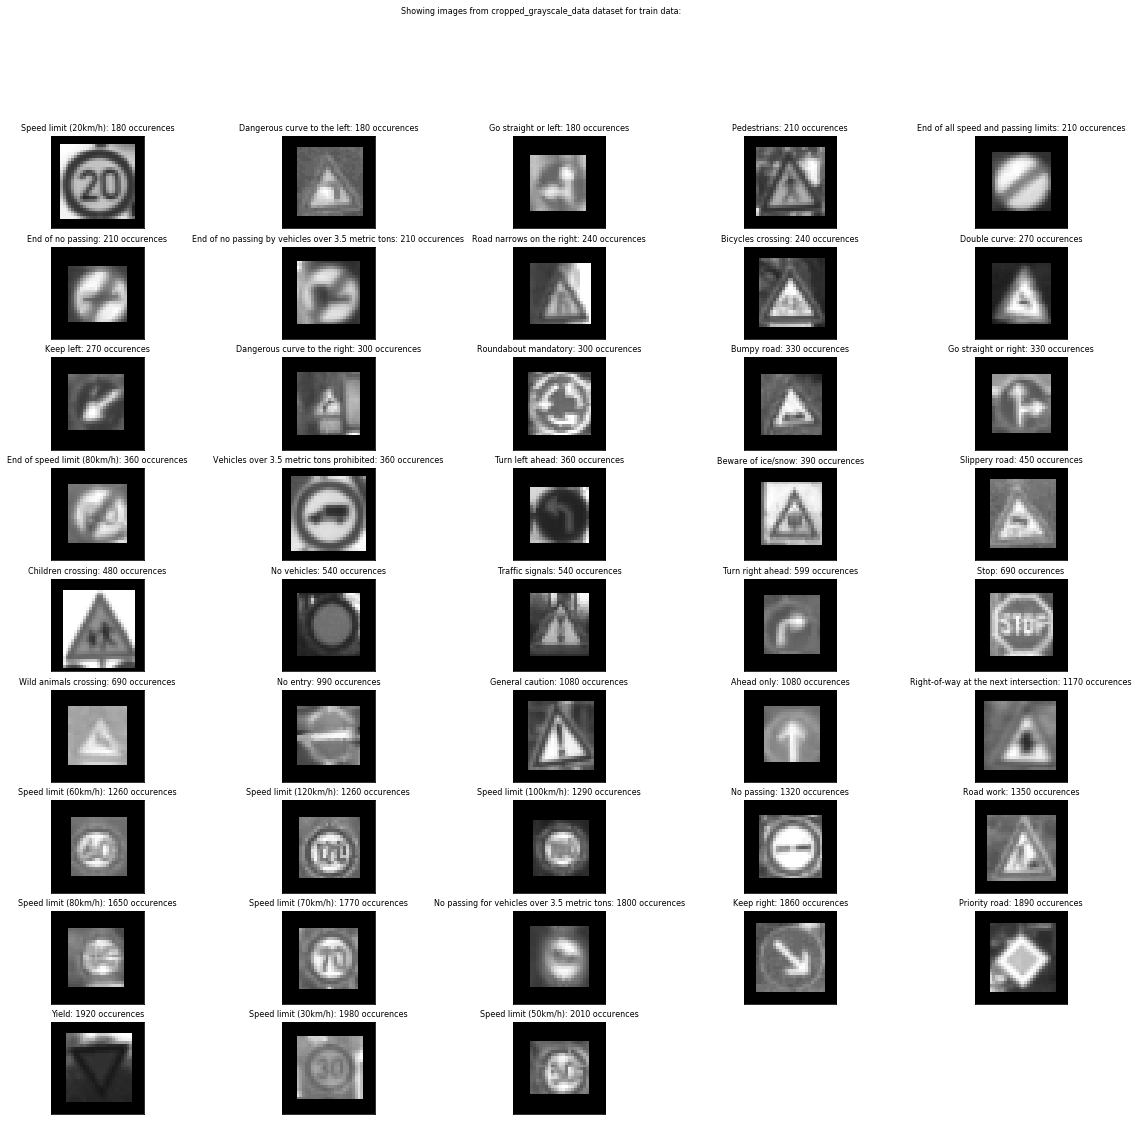

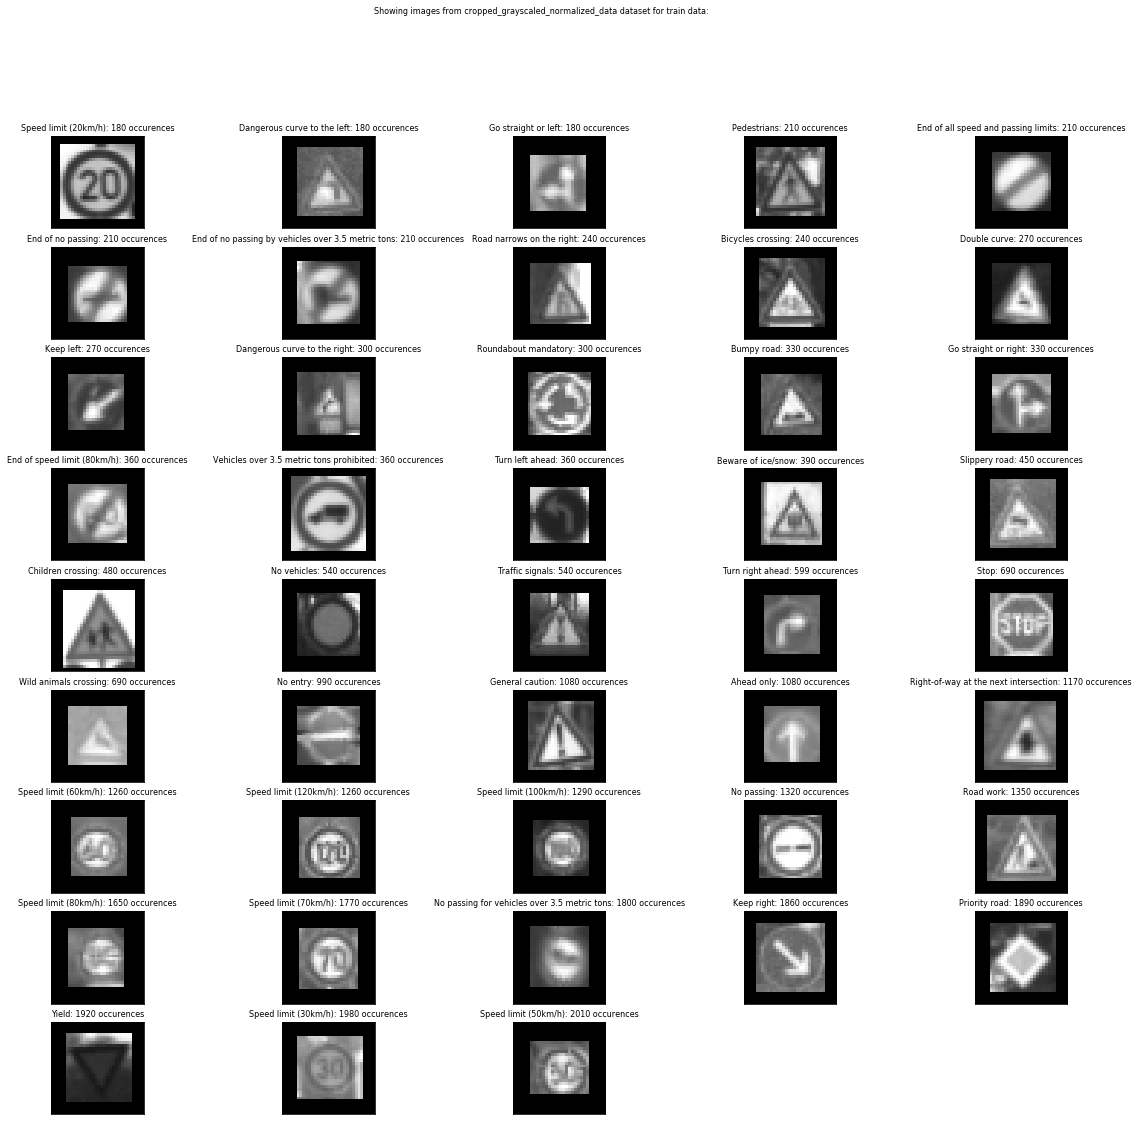

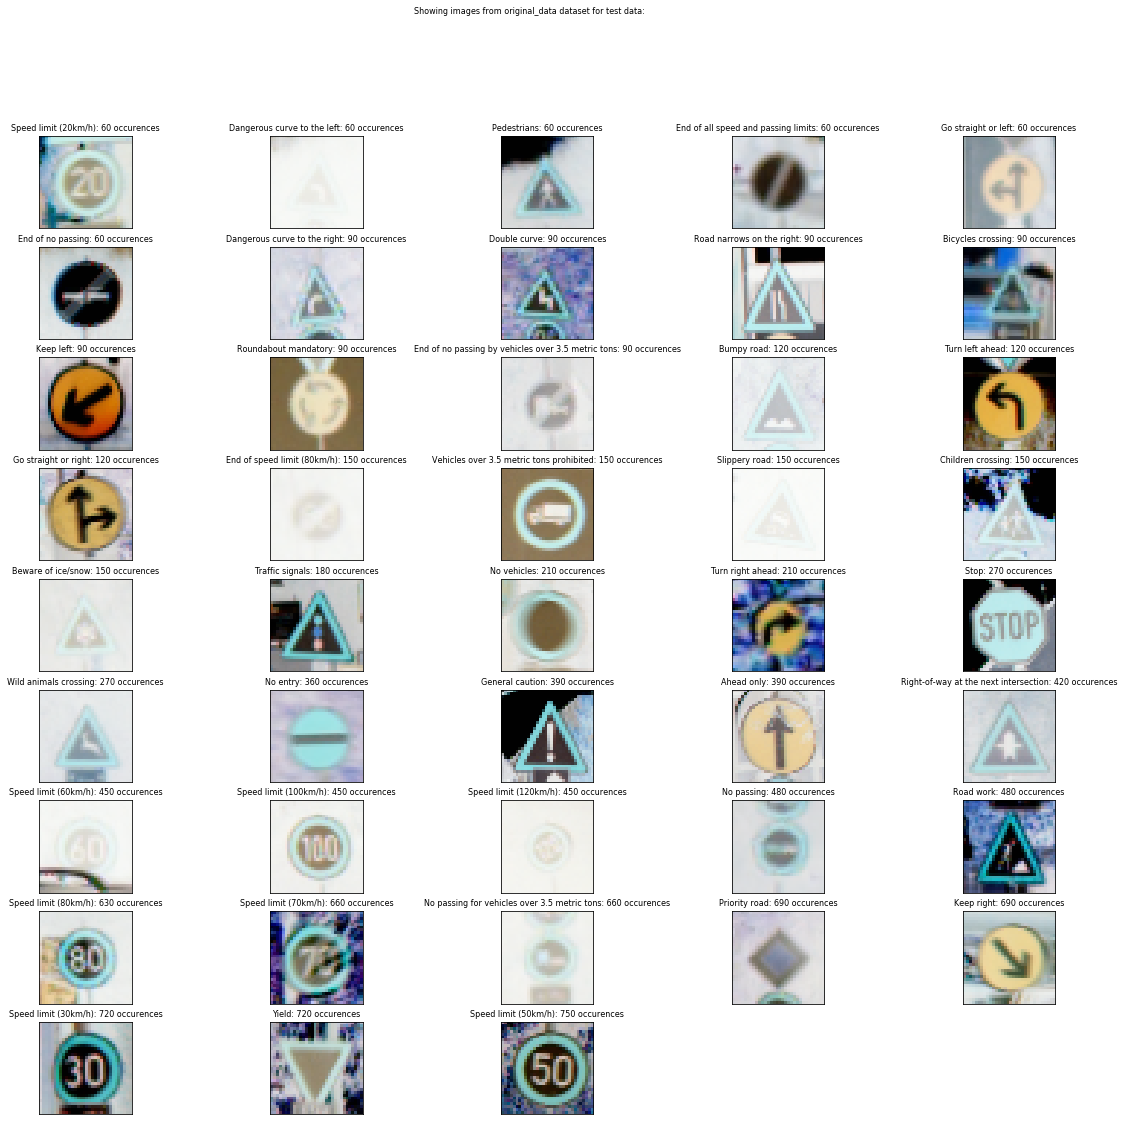

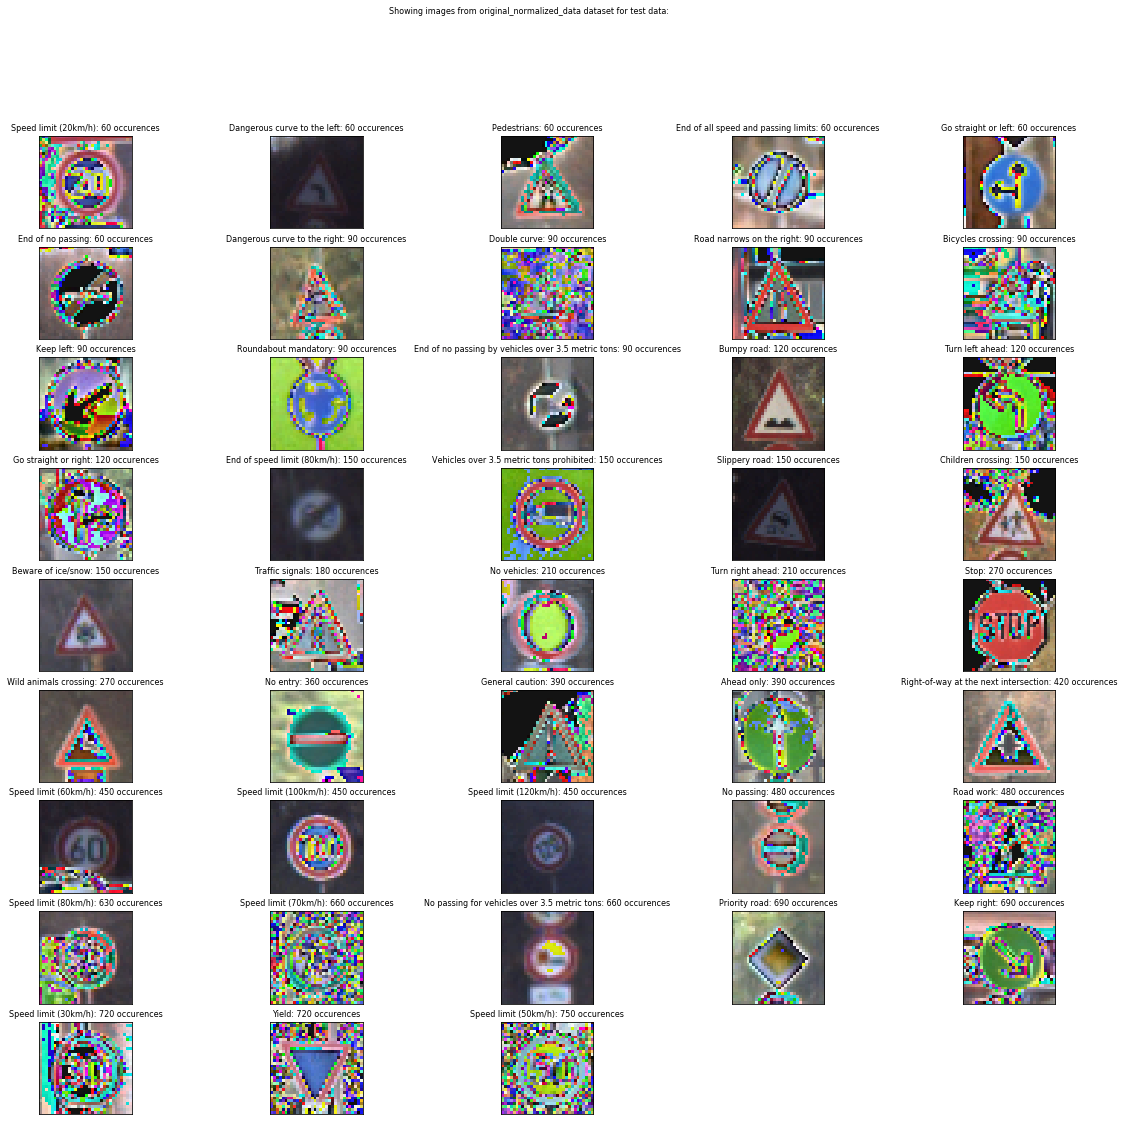

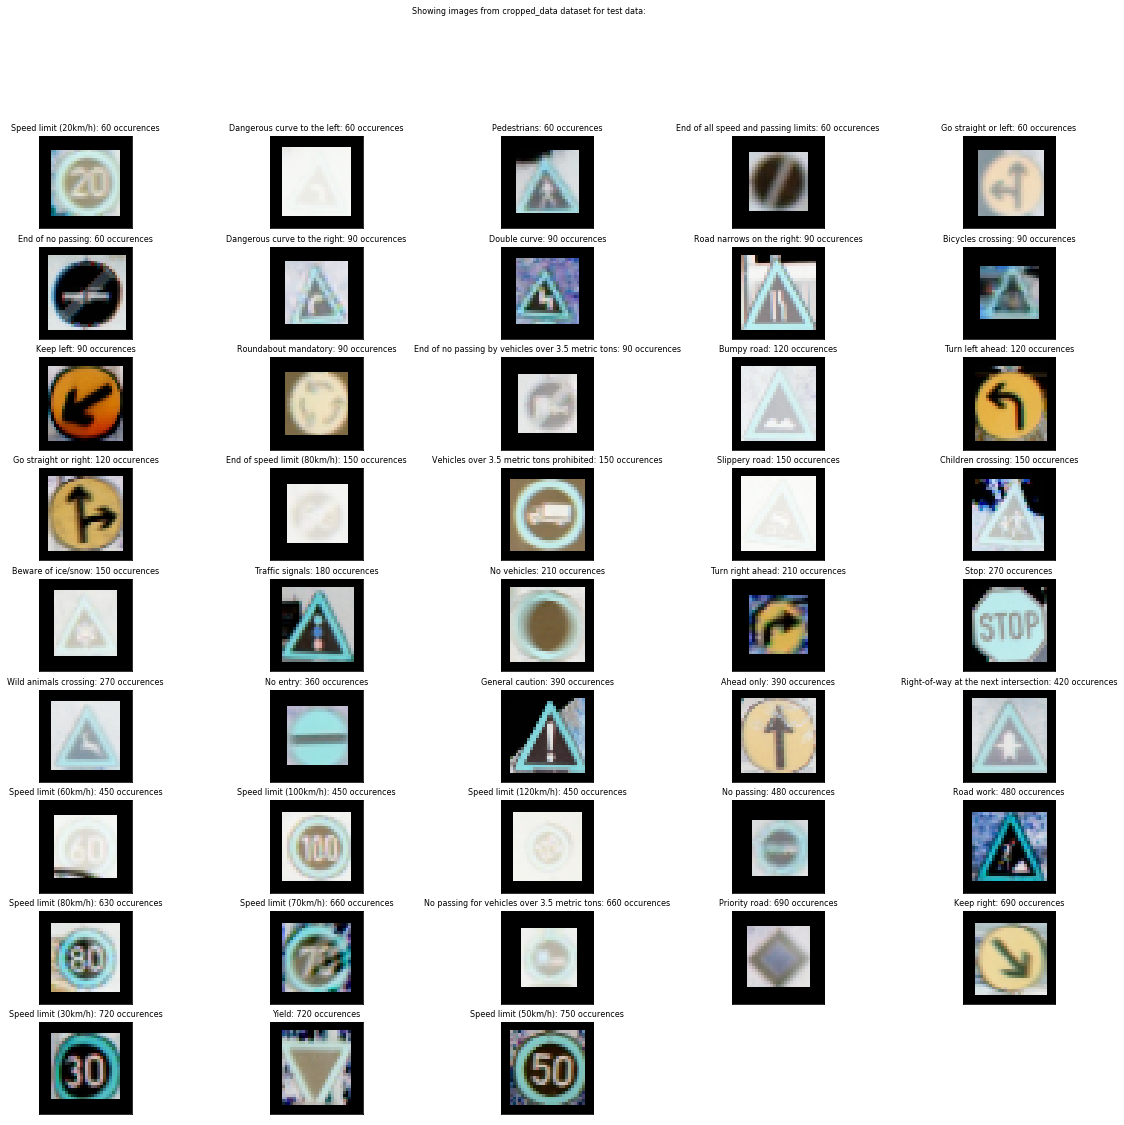

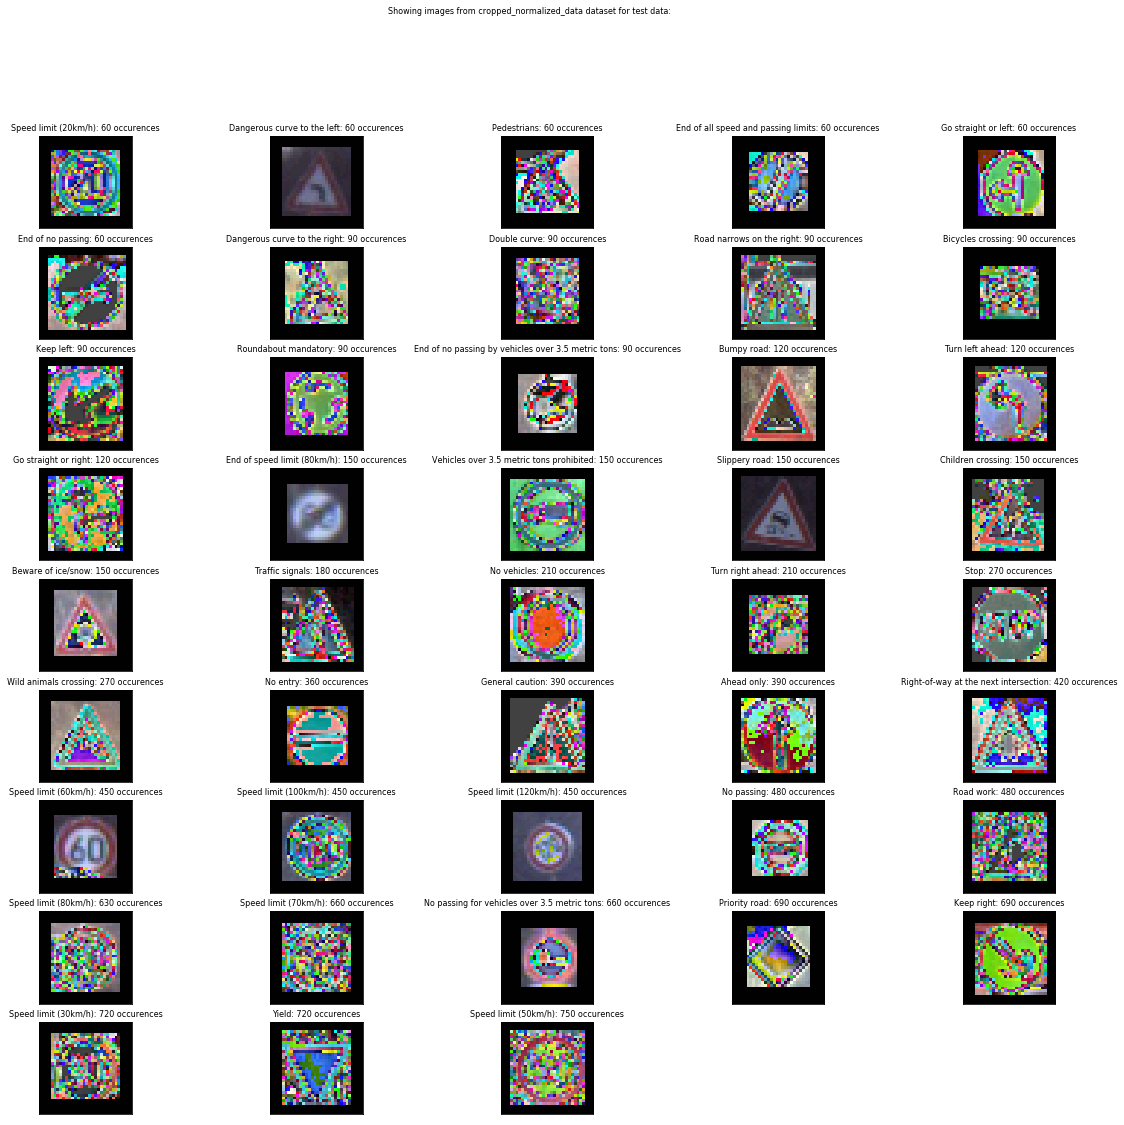

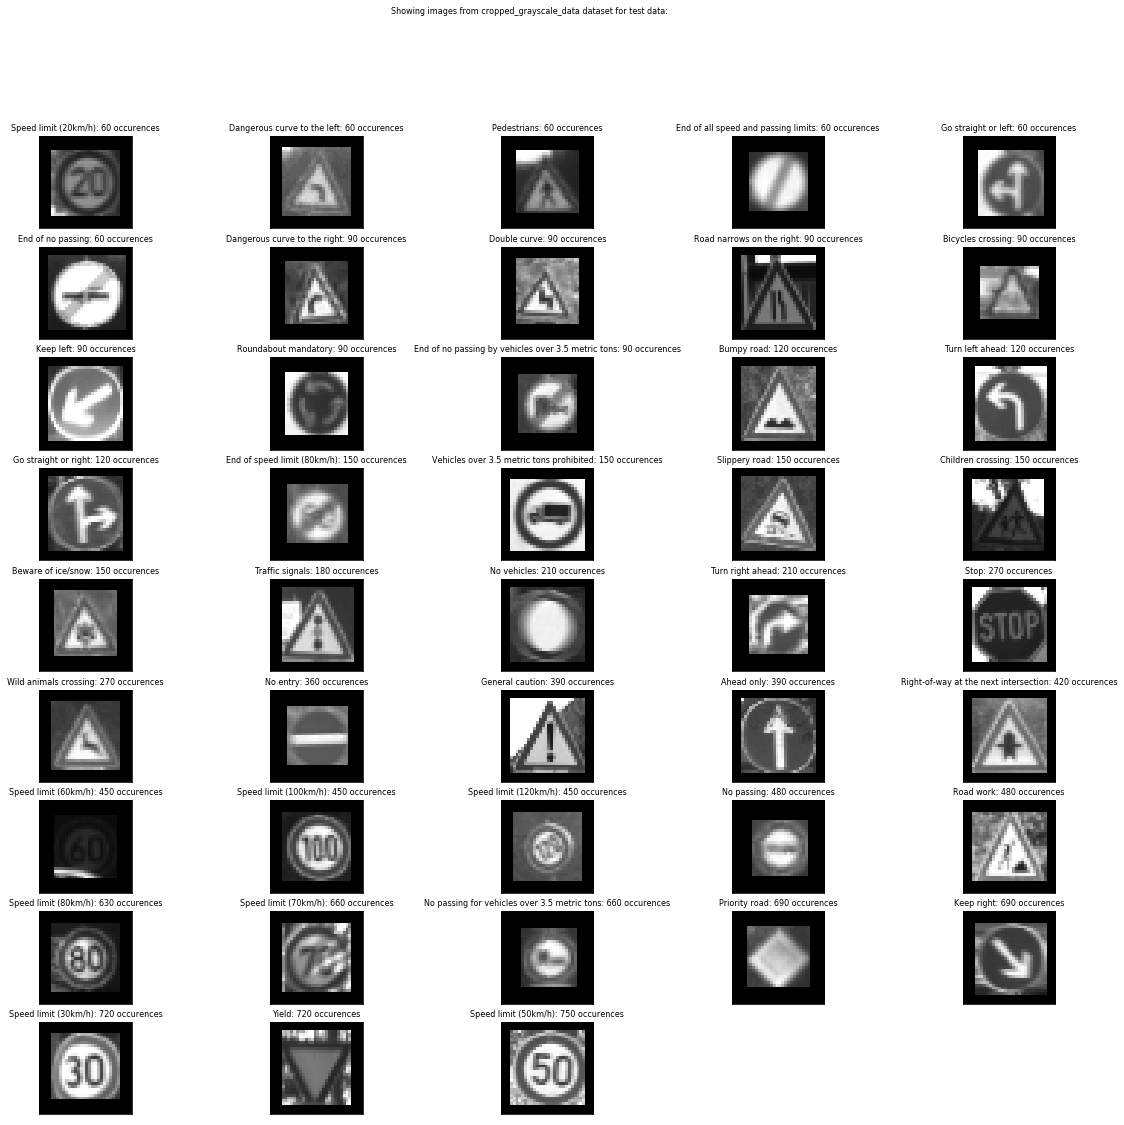

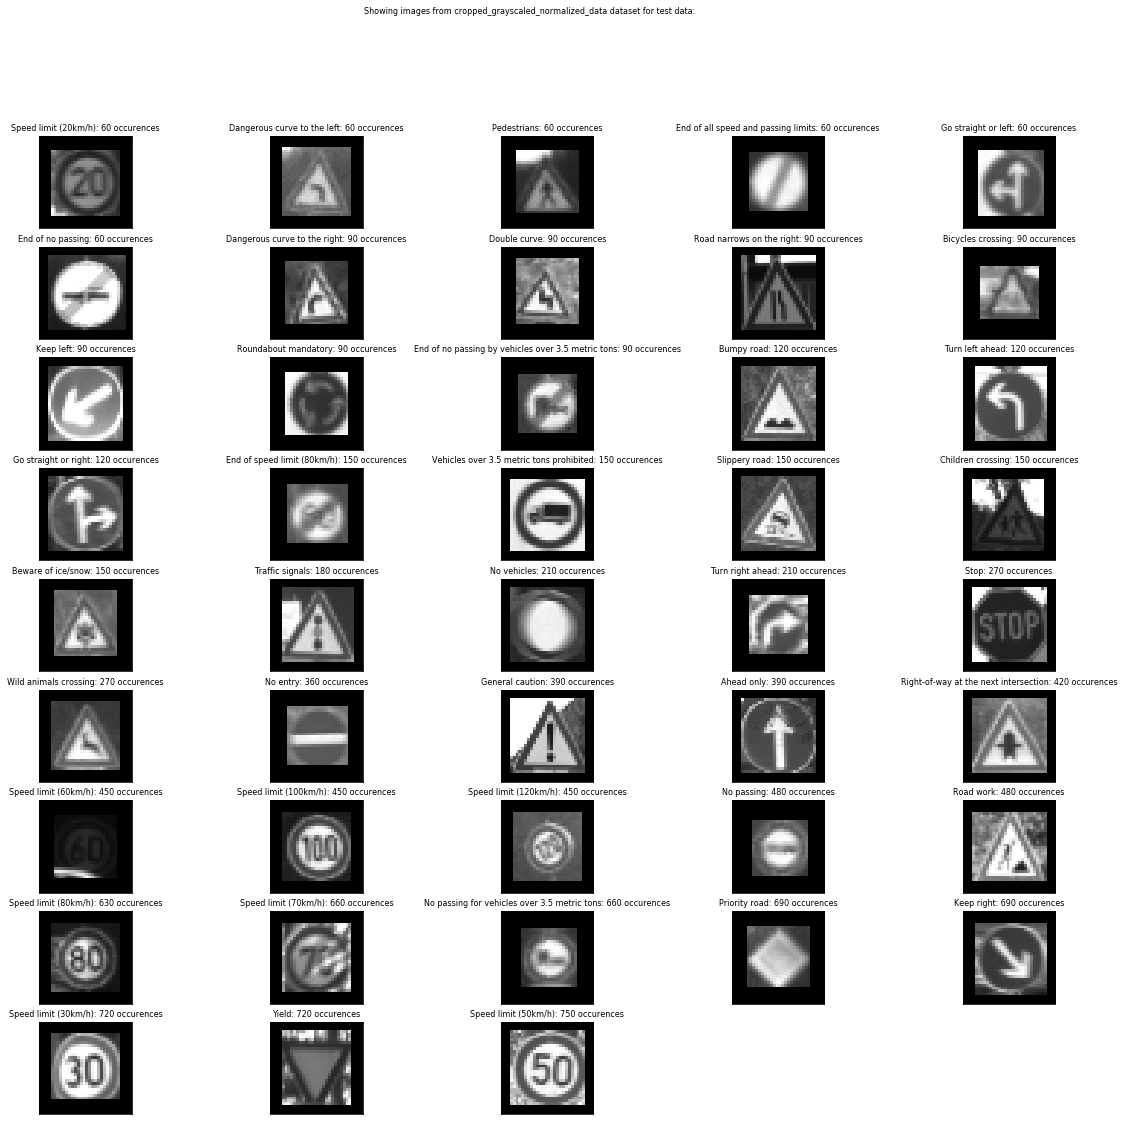

In [5]:
def show_data(all_data, data_suffix_key):
    for data_dict in all_data:
        title = 'Showing images from ' + data_dict['name'] + ' dataset for ' + data_suffix_key + ' data' + ":"
        feature_label_original_data = build_feature_label_ranked_dict(data_dict['X_' + data_suffix_key], data_dict['y_' + data_suffix_key])
        show_sample_images(list(feature_label_original_data.values()), len(list(feature_label_original_data.values())), signnames_dict, make_random=False, labels=list(feature_label_original_data.keys()), fig_title=title, CMAP=data_dict['cmap'])
    

show_data(all_data, 'train')
show_data(all_data, 'test')

### Use this as a refernce for recognizing keys to datasets:
#### original_data => Original images
#### original_normalized_data => Normalized images
#### cropped_data => Cropped images
#### cropped_grayscale_data => Cropped grayscaled images
#### cropped_normalized_data => Cropped normalized images
#### cropped_grayscaled_normalized_data => Cropped grayscaled normalized images

# Model generation and evaluation

Working on original_data...
Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)


Epoch: 100%|██████████| 500/500 [12:01<00:00,  1.51s/epochs]


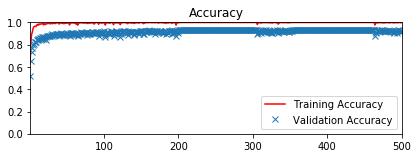

Test Accuracy = 0.912
5 images test data Accuracy = 0.800
+--------------------------+-------------------------+-------------------------+
|       Actual value       |     Predicted value     |      Other labels'      |
|                          |                         |       probability       |
+==========================+=========================+=========================+
| Speed limit (70km/h)     | Children crossing       | ['Children crossing:    |
|                          |                         | 1.0', 'Beware of        |
|                          |                         | ice/snow: 1.50745e-24', |
|                          |                         | 'General caution:       |
|                          |                         | 3.04669e-31', 'Vehicles |
|                          |                         | over 3.5 metric tons    |
|                          |                         | prohibited: 0.0',       |
|                          |                       

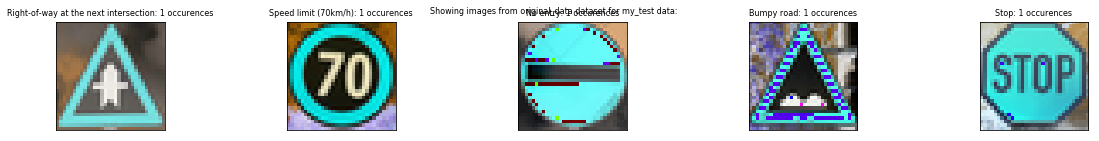

All done for original_data!
###############################################################################







Working on original_normalized_data...
Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)


Epoch: 100%|██████████| 500/500 [11:56<00:00,  1.48s/epochs]


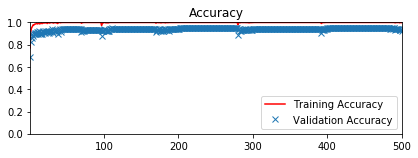

Test Accuracy = 0.928
5 images test data Accuracy = 0.600
+--------------------------+-------------------------+-------------------------+
|       Actual value       |     Predicted value     |      Other labels'      |
|                          |                         |       probability       |
+==========================+=========================+=========================+
| Speed limit (70km/h)     | Go straight or right    | ['Go straight or right: |
|                          |                         | 1.0', 'Speed limit      |
|                          |                         | (60km/h): 4.83206e-11', |
|                          |                         | 'Ahead only:            |
|                          |                         | 2.05812e-13', 'End of   |
|                          |                         | all speed and passing   |
|                          |                         | limits: 3.64619e-21',   |
|                          |                       

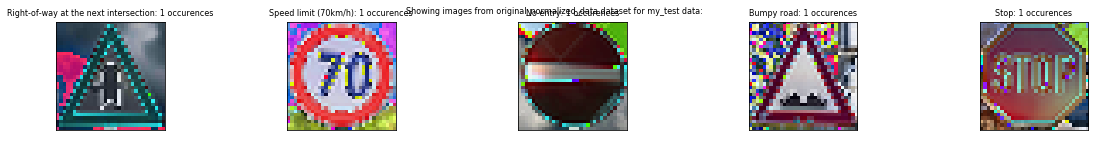

All done for original_normalized_data!
###############################################################################







Working on cropped_data...
Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)


Epoch: 100%|██████████| 500/500 [12:02<00:00,  1.46s/epochs]


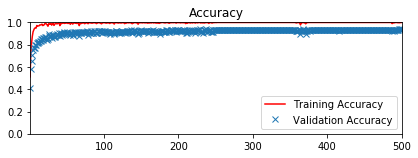

Test Accuracy = 0.932
5 images test data Accuracy = 0.600
+--------------------------+-------------------------+-------------------------+
|       Actual value       |     Predicted value     |      Other labels'      |
|                          |                         |       probability       |
+==========================+=========================+=========================+
| Speed limit (70km/h)     | Ahead only              | ['Ahead only: 1.0',     |
|                          |                         | 'Turn right ahead:      |
|                          |                         | 4.33396e-34', 'Vehicles |
|                          |                         | over 3.5 metric tons    |
|                          |                         | prohibited: 0.0',       |
|                          |                         | 'Speed limit (70km/h):  |
|                          |                         | 0.0', 'Pedestrians:     |
|                          |                       

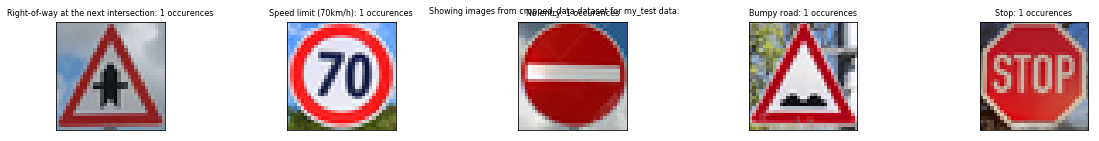

All done for cropped_data!
###############################################################################







Working on cropped_normalized_data...
Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)


Epoch: 100%|██████████| 500/500 [11:52<00:00,  1.43s/epochs]


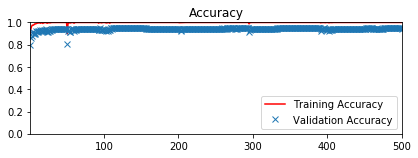

Test Accuracy = 0.937
5 images test data Accuracy = 0.600
+--------------------------+-------------------------+-------------------------+
|       Actual value       |     Predicted value     |      Other labels'      |
|                          |                         |       probability       |
+==========================+=========================+=========================+
| Speed limit (70km/h)     | Road work               | ['Road work: 1.0',      |
|                          |                         | 'Turn right ahead:      |
|                          |                         | 3.42943e-08', 'Speed    |
|                          |                         | limit (70km/h):         |
|                          |                         | 2.58681e-11', 'Yield:   |
|                          |                         | 1.32255e-11', 'Ahead    |
|                          |                         | only: 2.5801e-12']      |
+--------------------------+-----------------------

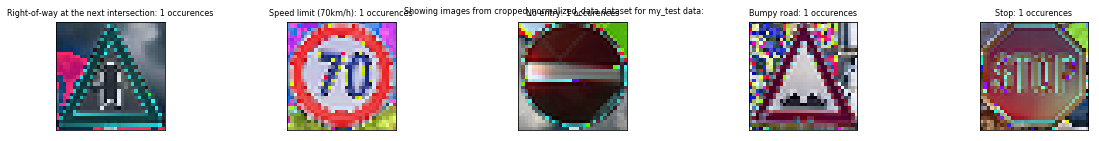

All done for cropped_normalized_data!
###############################################################################







Working on cropped_grayscale_data...
Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)


Epoch: 100%|██████████| 500/500 [09:43<00:00,  1.19s/epochs]


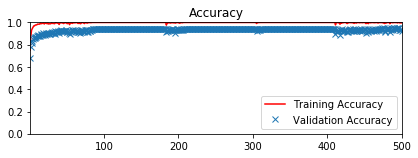

Test Accuracy = 0.901
5 images test data Accuracy = 0.400
+--------------------------+-------------------------+-------------------------+
|       Actual value       |     Predicted value     |      Other labels'      |
|                          |                         |       probability       |
+==========================+=========================+=========================+
| Speed limit (70km/h)     | Speed limit (20km/h)    | ['Speed limit (20km/h): |
|                          |                         | 1.0', 'Vehicles over    |
|                          |                         | 3.5 metric tons         |
|                          |                         | prohibited: 0.0',       |
|                          |                         | 'Speed limit (70km/h):  |
|                          |                         | 0.0', 'Pedestrians:     |
|                          |                         | 0.0', 'Double curve:    |
|                          |                       

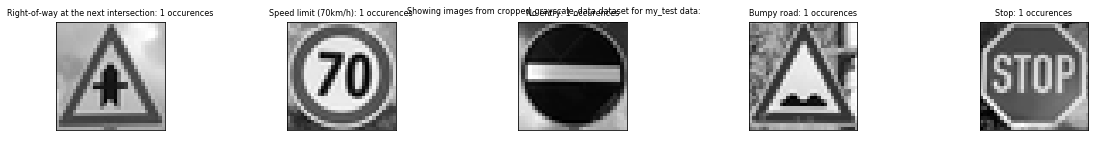

All done for cropped_grayscale_data!
###############################################################################







Working on cropped_grayscaled_normalized_data...
Stored 'current_data_dict' (dict)
Stored 'current_data_dict_name' (str)


Epoch: 100%|██████████| 500/500 [09:43<00:00,  1.22s/epochs]


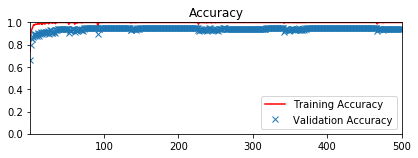

Test Accuracy = 0.931
5 images test data Accuracy = 0.800
+--------------------------+-------------------------+-------------------------+
|       Actual value       |     Predicted value     |      Other labels'      |
|                          |                         |       probability       |
+==========================+=========================+=========================+
| Speed limit (70km/h)     | Road work               | ['Road work: 0.876273', |
|                          |                         | 'Speed limit (70km/h):  |
|                          |                         | 0.118563', 'Dangerous   |
|                          |                         | curve to the right:     |
|                          |                         | 0.00481356', 'Speed     |
|                          |                         | limit (80km/h):         |
|                          |                         | 0.000345095',           |
|                          |                       

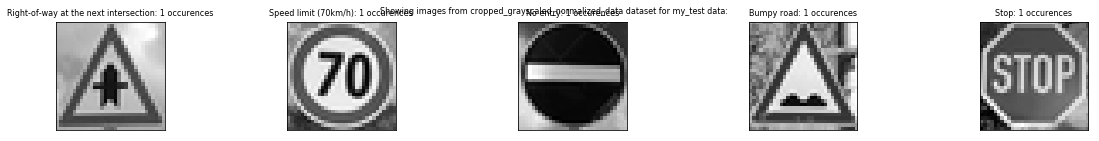

All done for cropped_grayscaled_normalized_data!
###############################################################################









In [6]:
#%%capture output
for index, data_dict in enumerate(all_data):
    current_data_dict = data_dict
    current_data_dict_name = data_dict['name']
    print("Working on " + current_data_dict_name + "...")
    %store current_data_dict
    %store current_data_dict_name
    %run LeNet_eval.ipynb 'current_data_dict'
    print("All done for " + current_data_dict_name + "!")
    print("###############################################################################"+ "\n\n\n\n\n\n\n")